# CPSC 4970 AI + ML: Module 6 -- combining SOM with MLP

[sklearn-som documentation](https://pypi.org/project/sklearn-som/)

In [7]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn_som.som import SOM
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# Fit 5x5 SOM to Iris data set

In [8]:
df = load_iris(as_frame=True)['frame']
print(df.shape)
print(df.columns)

(150, 5)
Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)', 'target'],
      dtype='object')


In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, 0:-1], df['target'])

In [10]:
som = SOM(m=5, n=5, dim=df.shape[1]-1)
som.fit(X_train.values)
print(som.predict(X_train.values))

[17 18 14 11  8 19  6  1 17  1  9  9  1  4  3 12  0 12  0  0  9  6  1 23
 12 18 14  6  1 12 14 14  6 14 13  8 14  3  9  9  0  4 18  3 19 18  3  1
  9  0  8 13 19 14  9  2  2 13 19 18  9 14  1  1  9  0  1 18  1 14  3 19
 13  6 17 17  0 17  1  9  1  0  1 14  5  6 22  1  0  9 18  1 19 19 14  0
 23  9  1 22 13  1 13  1 19 12  8  6  3  1  9  0]


In [11]:
aug_X_train = np.append(X_train, som.predict(X_train.values).reshape(-1, 1), axis=1)
print(X_train.shape)
print(aug_X_train.shape)
aug_X_test = np.append(X_test, som.predict(X_test.values).reshape(-1, 1), axis=1)
print(X_test.shape)
print(aug_X_test.shape)

pipeline = Pipeline(
    [('preproc', make_column_transformer(
        (OneHotEncoder(handle_unknown='ignore'), [aug_X_train.shape[1]-1]),
        (StandardScaler(), slice(0, aug_X_train.shape[1]-1)))),
     ('classifier', MLPClassifier(max_iter=2000))]
)

cv_params = {
    'classifier__hidden_layer_sizes': [(10, ), (20, ), (40, ), (80, ),
                                       (10, 5), (20, 10), (40, 20), (80, 40)],
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
}

cv = GridSearchCV(pipeline, cv_params, n_jobs=-1)
cv.fit(aug_X_train, y_train)
print("Training accuracy:", accuracy_score(y_train, cv.predict(aug_X_train)))
print("Testing accuracy:", accuracy_score(y_test, cv.predict(aug_X_test)))

(112, 4)
(112, 5)
(38, 4)
(38, 5)
Training accuracy: 1.0
Testing accuracy: 0.8947368421052632


{'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (80, 40)}


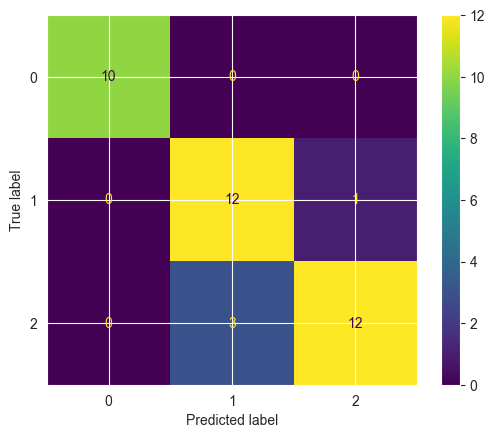

In [12]:
print(cv.best_params_)
ConfusionMatrixDisplay.from_estimator(cv, aug_X_test, y_test)